In [27]:
import math

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [103]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [28]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor()])
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [29]:
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=2)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [56]:
from math import sqrt, ceil

def show_images(dataset, amount):
    grid_size = ceil(sqrt(amount))
    fig = plt.figure(figsize=(grid_size * 2, grid_size * 2))
    for i in range(amount):
        fig.add_subplot(grid_size,grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(transforms.ToPILImage()(dataset[i][0]))
        # print(type(train_set[i][0]))
        # plt.imshow(train_set[i][0])
        plt.xlabel(class_names[dataset[i][1]])

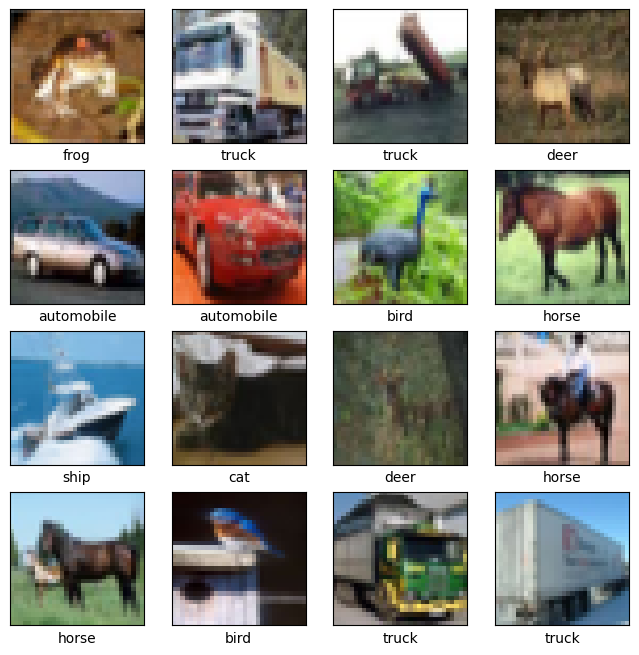

In [60]:
show_images(train_set, 16)

In [145]:
import torch.nn as nn
import torch.nn.functional as f


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.softmax(x)
        return x


net = Net().to(device)

In [146]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [147]:
from torchviz import make_dot

batch = next(iter(train_loader))
y = net(batch[0]) # Give dummy batch to forward().

make_dot(y.mean(), params=dict(net.named_parameters()))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [148]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [149]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.279
[1,  4000] loss: 2.063
[1,  6000] loss: 1.926
[1,  8000] loss: 1.845
[1, 10000] loss: 1.745
[1, 12000] loss: 1.687
[2,  2000] loss: 1.614
[2,  4000] loss: 1.562
[2,  6000] loss: 1.555
[2,  8000] loss: 1.499
[2, 10000] loss: 1.482
[2, 12000] loss: 1.470
Finished Training


In [150]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

In [151]:
outputs = net(images)

In [152]:
_, predicted = torch.max(outputs, 1)

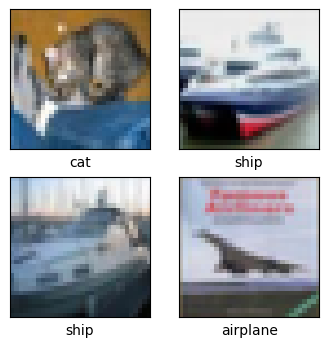

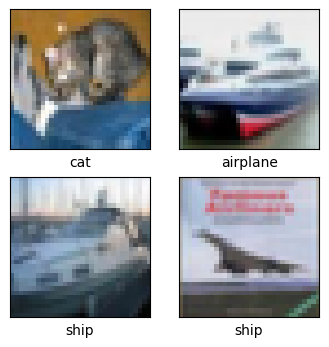

In [153]:
show_images(list(zip(images, labels)), 4)

show_images(list(zip(images, predicted)), 4)

In [157]:
correct = 0
total = 0
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 49 %
Accuracy for class: airplane is 62.7 %
Accuracy for class: automobile is 55.5 %
Accuracy for class: bird  is 38.4 %
Accuracy for class: cat   is 18.4 %
Accuracy for class: deer  is 41.2 %
Accuracy for class: dog   is 40.5 %
Accuracy for class: frog  is 63.9 %
Accuracy for class: horse is 59.7 %
Accuracy for class: ship  is 52.6 %
Accuracy for class: truck is 57.9 %


In [155]:
# prepare to count predictions for each class

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.3f} %')

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device